In [2]:
import numpy as np
import cv2
import os
from skimage.feature import local_binary_pattern
import copy
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import validation_curve
from skimage.feature import hog
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib 
import time

In [3]:
def scrapeFile(file):
    filepath = file
    X={}
    Y={}
    with open(filepath) as fp:  
        line = fp.readline()      
        while line:
            l=line.strip()
            a=l.split(",")
            temp=[]
            for p in a[1:]:
                temp.append(float(p))
            X[int(a[0])]=temp
            Y[int(a[0])]=np.argmax(temp)
            line = fp.readline()
    return X,Y

In [4]:
def hog_f(image):
    hist = hog(image,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    temp=[]
    for j in range(len(hist)):
        temp.append(hist[j])
    return temp

In [5]:
def lbp_f(image):
    lbp = local_binary_pattern(image,8,1,'uniform') 
    lbp_hist = np.histogram(lbp, bins=np.arange(257), density=True)[0]
    return list(lbp_hist)

In [6]:
def color_lbp_f(image):
    R=image[:,:,2]
    G=image[:,:,1]
    B=image[:,:,0]    
    lbp_r = local_binary_pattern(R,8,1,'uniform')
    lbp_g = local_binary_pattern(G,8,1,'uniform')
    lbp_b = local_binary_pattern(B,8,1,'uniform') 
    l_r = np.histogram(lbp_r, bins=np.arange(257), density=True)[0]
    l_g = np.histogram(lbp_g, bins=np.arange(257), density=True)[0]
    l_b = np.histogram(lbp_b, bins=np.arange(257), density=True)[0] 
    return list(l_b)+list(l_g)+list(l_r)

In [7]:
def color_hog_f(image):
    R=image[:,:,2]
    G=image[:,:,1]
    B=image[:,:,0]
    hist_R =hog(R,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    hist_G=hog(G,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    hist_B=hog(B,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    temp1=[]
    temp2=[]
    temp3=[]
    for j in range(len(hist_R)):
        temp1.append(hist_R[j])
        temp2.append(hist_G[j])
        temp3.append(hist_B[j])
    return temp3+temp2+temp1

In [8]:
###########################PCA############################
def pca_feature(X):
    pca=PCA(n_components=0.99)
    pca.fit(X)
    newX=(pca.transform(X))
    return list(newX)

In [9]:
###################MOMENTS FEATURE#########################
def image_moment_feature(image):
    ret,thresh = cv2.threshold(image,80,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    #print(np.shape(contours))
    cnt = contours[0]
    M = cv2.moments(cnt)
    f=[]
    for k in M:
        f.append(M[k])
    return list(f)

In [10]:
def feature_extraction(img,gray):
    featureset=[]
    #featureset+=lbp_f(gray)
    featureset+=image_moment_feature(gray)
    #featureset+=hog_f(gray)
    return featureset

In [11]:
def qwise_prediction(prediction):
    prediction=np.array(prediction)
    prediction=prediction.T
    Q1_pred=normalize(prediction[:,0:3])
    Q2_pred=normalize(prediction[:, 3:5])
    Q3_pred=normalize(prediction[:, 5:7])
    Q4_pred=normalize(prediction[:, 7:9])
    Q5_pred=normalize(prediction[:, 9:13])
    Q6_pred=normalize(prediction[:, 13:15])
    Q7_pred=normalize(prediction[:, 15:18])
    Q8_pred=normalize(prediction[:, 18:25])
    Q9_pred=normalize(prediction[:, 25:28])
    Q10_pred=normalize(prediction[:, 28:31])
    Q11_pred=normalize(prediction[:, 31:37])
    result=[Q1_pred,Q2_pred,Q3_pred,Q4_pred,Q5_pred,Q6_pred,Q7_pred,Q8_pred,Q9_pred,Q10_pred,Q11_pred]
    return result


In [12]:
def rmse_calculation(y_true,prediction):
    mse=[]
    for i in range(11):
        y=np.array(y_true[i].iloc[7000:10000])
        mse.append(mean_squared_error(y,prediction[i]))
    return mse

In [13]:
def plotGraph(x,y):
    plt.bar(x,y)
    plt.xlabel("Question")
    plt.ylabel("RMSE")
    plt.show()

In [30]:
def normalize(zl):
    e_x = np.exp(zl - np.max(zl))
    gz=e_x / e_x.sum()
    y=gz/gz.sum(axis=1)[:,None]
    return y

In [14]:
df=pd.read_csv("training_solutions_rev1.csv")
y=["GalaxyID"]
for x in df.columns[1:]:
    y.append(x[-1])
df.columns=y

In [15]:
#Separation of questions
Q1=df.iloc[:, 1:4]
q1=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q2=df.iloc[:, 4:6]
q2=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q3=df.iloc[:, 6:8]
q3=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q4=df.iloc[:, 8:10]
q4=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q5=df.iloc[:, 10:14]
q5=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q6=df.iloc[:, 14:16]
q6=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q7=df.iloc[:, 16:19]
q7=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q8=df.iloc[:, 19:26]
q8=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q9=df.iloc[:, 26:29]
q9=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q10=df.iloc[:, 29:32]
q10=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q11=df.iloc[:, 32:38]
q11=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q_idx=[Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11]

In [16]:
train_ids=np.array(q1["GalaxyID"])[0:7000]
test_ids=np.array(q1["GalaxyID"])[7000:10000]

In [17]:
X,Y=scrapeFile("training_solutions")


In [18]:
train_features=[]
datapath="images_training_rev1/"
train_features=[]
for i in range(7000):
    path="images_training_rev1/"+str(train_ids[i])+".jpg"
    image=cv2.imread(path)
    gray=cv2.imread(path,0)
    crop1 = image[108:108+207, 108:108+207]
    crop2 = gray[108:108+207, 108:108+207]
    feature=feature_extraction(crop1,crop2)
    train_features.append(feature)
    if i%1000==0:
        print(i,"..Done")

0 ..Done
1000 ..Done
2000 ..Done
3000 ..Done
4000 ..Done
5000 ..Done
6000 ..Done


In [19]:
len(train_features[0])

24

In [20]:
test_features=[]
for i in range(3000):
    path="images_training_rev1/"+str(test_ids[i])+".jpg"
    image=cv2.imread(path)
    gray=cv2.imread(path,0)
    crop1 = image[108:108+207, 108:108+207]
    crop2 = gray[108:108+207, 108:108+207]
    feature=feature_extraction(crop1,crop2)
    test_features.append(feature)
    if i%1000==0:
        print(i,"..Done")

0 ..Done
1000 ..Done
2000 ..Done


In [21]:
datapath="images_training_rev1/"
files_list = sorted(os.listdir(datapath))
dataset=[]
datalabel=[]
category=defaultdict(list)
featureset=[]
idx=0
for file in files_list[0:10000]:
    id1=int(file[:-4])
    datalabel.append(X[id1])
    for i in range(37):
        category[i].append(X[id1][i])
    idx+=1
    if idx%1000==0:
        print(idx,"..Done")
    


1000 ..Done
2000 ..Done
3000 ..Done
4000 ..Done
5000 ..Done
6000 ..Done
7000 ..Done
8000 ..Done
9000 ..Done
10000 ..Done


In [22]:
prediction_LR=[]
for i in range(37):
    start=time.time()
    clf = LinearRegression().fit(train_features,np.array(df.iloc[:,i+1])[0:7000] )
    file_name="C"+str(i+1)+"_linear.pkl"
    joblib.dump(clf, file_name) 
    y_predict=clf.predict(test_features)
    end=time.time()
    prediction_LR.append(y_predict)  
    print(i,"..Done","Time=",end-start)
    #rmse=mean_squared_error(y_true, y_predict)

0 ..Done Time= 0.024959325790405273
1 ..Done Time= 0.02004408836364746
2 ..Done Time= 0.01864027976989746
3 ..Done Time= 0.02529454231262207
4 ..Done Time= 0.031626224517822266
5 ..Done Time= 0.031287193298339844
6 ..Done Time= 0.022536754608154297
7 ..Done Time= 0.0181429386138916
8 ..Done Time= 0.01818704605102539
9 ..Done Time= 0.018805742263793945
10 ..Done Time= 0.03127145767211914
11 ..Done Time= 0.0320429801940918
12 ..Done Time= 0.027498245239257812
13 ..Done Time= 0.021029949188232422
14 ..Done Time= 0.01858687400817871
15 ..Done Time= 0.0185391902923584
16 ..Done Time= 0.018661022186279297
17 ..Done Time= 0.01850581169128418
18 ..Done Time= 0.019968748092651367
19 ..Done Time= 0.019323348999023438
20 ..Done Time= 0.01851487159729004
21 ..Done Time= 0.018363237380981445
22 ..Done Time= 0.018935680389404297
23 ..Done Time= 0.021384239196777344
24 ..Done Time= 0.018544435501098633
25 ..Done Time= 0.018505096435546875
26 ..Done Time= 0.018406391143798828
27 ..Done Time= 0.0186364

In [23]:
prediction_LoR=[]
for i in range(37):
    start=time.time()
    clf = Lasso().fit(train_features,np.array(df.iloc[:,i+1])[0:7000] )
    file_name="C"+str(i+1)+"_lasso"+".pkl"
    joblib.dump(clf, file_name) 
    y_predict=clf.predict(test_features)
    end=time.time()
    prediction_LoR.append(y_predict)  
    print(i,"..Done","Time=",end-start)
    #rmse=mean_squared_error(y_true, y_predict)

/home/drago/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0 ..Done Time= 0.3173515796661377
1 ..Done Time= 0.19277524948120117
2 ..Done Time= 0.20586585998535156
3 ..Done Time= 0.19301390647888184
4 ..Done Time= 0.19427776336669922
5 ..Done Time= 0.19423222541809082
6 ..Done Time= 0.1974177360534668
7 ..Done Time= 0.20645904541015625
8 ..Done Time= 0.23174428939819336
9 ..Done Time= 0.19003987312316895
10 ..Done Time= 0.19237828254699707
11 ..Done Time= 0.18903255462646484
12 ..Done Time= 0.1987905502319336
13 ..Done Time= 0.21511030197143555
14 ..Done Time= 0.21270251274108887
15 ..Done Time= 0.19068670272827148
16 ..Done Time= 0.1913309097290039
17 ..Done Time= 0.19533920288085938
18 ..Done Time= 0.19501590728759766
19 ..Done Time= 0.19021391868591309
20 ..Done Time= 0.18558168411254883
21 ..Done Time= 0.19098234176635742
22 ..Done Time= 0.239501953125
23 ..Done Time= 0.19633841514587402
24 ..Done Time= 0.1884002685546875
25 ..Done Time= 0.19516229629516602
26 ..Done Time= 0.19835615158081055
27 ..Done Time= 0.19565510749816895
28 ..Done Ti

In [24]:
prediction_RR=[]
for i in range(37):
    start=time.time()
    clf = Ridge().fit(train_features,np.array(df.iloc[:,i+1])[0:7000] )
    file_name="C"+str(i+1)+"_ridge"+".pkl"
    joblib.dump(clf, file_name) 
    y_predict=clf.predict(test_features)
    end=time.time()
    prediction_RR.append(y_predict)  
    print(i,"..Done","Time=",end-start)
    #rmse=mean_squared_error(y_true, y_predict)

0 ..Done Time= 0.14567875862121582
1 ..Done Time= 0.0160214900970459
2 ..Done Time= 0.016055822372436523


/home/drago/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.724534e-24
  overwrite_a=True).T


3 ..Done Time= 0.016497135162353516
4 ..Done Time= 0.019107818603515625
5 ..Done Time= 0.017565250396728516
6 ..Done Time= 0.016515493392944336
7 ..Done Time= 0.016100406646728516
8 ..Done Time= 0.01607799530029297
9 ..Done Time= 0.015917539596557617
10 ..Done Time= 0.016052722930908203
11 ..Done Time= 0.015923738479614258
12 ..Done Time= 0.016545534133911133
13 ..Done Time= 0.018970727920532227
14 ..Done Time= 0.01636672019958496
15 ..Done Time= 0.016350746154785156
16 ..Done Time= 0.021818161010742188
17 ..Done Time= 0.028163433074951172
18 ..Done Time= 0.027989625930786133
19 ..Done Time= 0.028108596801757812
20 ..Done Time= 0.028075695037841797
21 ..Done Time= 0.028007984161376953
22 ..Done Time= 0.028678178787231445
23 ..Done Time= 0.028197526931762695
24 ..Done Time= 0.0286252498626709
25 ..Done Time= 0.028269529342651367
26 ..Done Time= 0.02814316749572754
27 ..Done Time= 0.027112245559692383
28 ..Done Time= 0.01627182960510254
29 ..Done Time= 0.016304731369018555
30 ..Done Time

In [31]:
qwise_pred_LR=qwise_prediction(prediction_LR)
qwise_mse_LR=rmse_calculation(Q_idx,qwise_pred_LR)
qwise_pred_LoR=qwise_prediction(prediction_LoR)
qwise_mse_LoR=rmse_calculation(Q_idx,qwise_pred_LoR)
qwise_pred_RR=qwise_prediction(prediction_RR)
qwise_mse_RR=rmse_calculation(Q_idx,qwise_pred_RR)

In [32]:
print(qwise_mse_LR)
print(qwise_mse_LoR)
print(qwise_mse_RR)

[0.07776083723227388, 0.1263842610156445, 0.12897466689267892, 0.13699003008404487, 0.042867747991619194, 0.0673558458805449, 0.07640211689492869, 0.018058049725884963, 0.0993104068450551, 0.08558603783620879, 0.0280181726188241]
[0.07790185095326717, 0.126312639328812, 0.12881658247861874, 0.13695367719244475, 0.04285409465930696, 0.0676119633563631, 0.07634711707288645, 0.018062729626956285, 0.0993089036008359, 0.08548885858858302, 0.028004903863081767]
[0.07776938508426824, 0.12638658271626604, 0.1289613362119226, 0.1370329458204284, 0.04287327000721812, 0.06732082913973665, 0.07640395506491522, 0.018048784895245782, 0.09931617326321802, 0.08555808407301935, 0.028005766459842752]


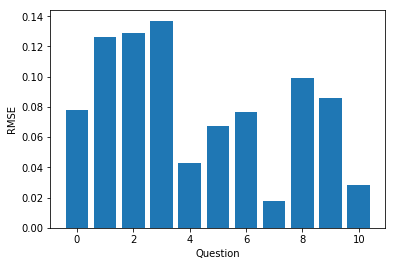

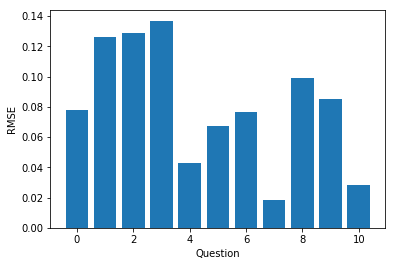

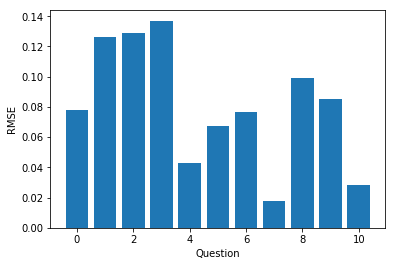

In [33]:
q=np.arange(11)
plotGraph(q,qwise_mse_LR)
plotGraph(q,qwise_mse_LoR)
plotGraph(q,qwise_mse_RR)

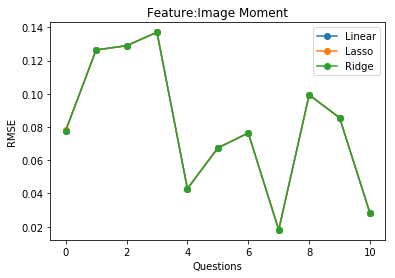

In [34]:
plt.plot(q,qwise_mse_LR,marker='o')
plt.plot(q,qwise_mse_LoR,marker='o')
plt.plot(q,qwise_mse_RR,marker='o')
plt.xlabel("Questions")
plt.ylabel("RMSE")
plt.legend(["Linear","Lasso","Ridge"])
plt.title("Feature:Image Moment")
plt.show()